# Segmentación mediante Watershed
#### Grupo 1: Mariana Nakagawa,María Pardo y Gema Perez.
---

Índice del Notebook:
1. Preparación de imágenes 
2. Conceptos teóricos del algoritmo Watershed
3. Flujo de la función .WatershedExerciseP2() creada
4. Ejemplo y discusión de resultados
5. Referencias
6. Autoría

## 1. Preparación de las imágenes

##### Importación de librerías

En esta sección vamos a proceder a visualizar las imágenes que hemos obtenido del repositorio de bases de datos Open Neuro, para poder evaluar los resultados de filtrado que debemos realizar. 

En primer lugar, cargaremos las imágenes con las que testearemos nuestro código. Se trata de imágenes de fMRI.

In [11]:
import os
import numpy as np
import nibabel as nib #nos permite leer las imagenes
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
import skimage
from skimage import io
from skimage import filters
from nilearn import datasets
from nilearn import plotting
import modules
from scipy import ndimage

In [2]:
#img1 = nib.load(r'\Users\Maria\Desktop\data\sub-01\anat\sub-01_T1w.nii.gz')
#img2 = nib.load(r"\Users\Maria\Desktop\data\sub-17\anat\sub-17_T1w.nii.gz")
#img3 = nib.load(r"\Users\Maria\Desktop\data\sub-26\anat\sub-26_T1w.nii.gz")
#img4 = nib.load(r"\Users\Maria\Desktop\data\sub-31\anat\sub-31_T1w.nii.gz")
#img5 = nib.load(r"\Users\Maria\Desktop\data\sub-13\anat\sub-13_T1w.nii.gz")
#img6 = nib.load(r"\Users\Maria\Desktop\data\sub-15\anat\sub-15_T1w.nii.gz")

In [3]:
img1 = nib.load(r'\Users\nakag\OneDrive\Escritorio\squizo\sub-02\anat\sub-02_T1w.nii.gz')

In [4]:
data = img1.get_fdata()  

In [5]:
print(data.shape)

(176, 256, 256)


In [6]:
print(data.dtype, img1.get_data_dtype())

float64 float32


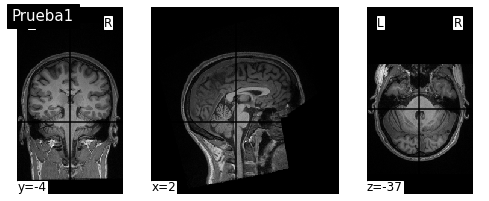

In [7]:
plotting.plot_img(img1, title="Prueba1",display_mode='ortho',cmap=plt.cm.gray )
plotting.show()  

Para poder añadirle el ruido a las imágenes, vamos a transformar los datos al formato array, y tras ello guardaremos un único corte (que hemos elegido de manera aleatoria) al que realizaremos la adición.

> En caso de querer disminuir el tiempo de ejecución descomente una de las líneas para disminuír el tamaño de las imágenes y por ende, el número de píxeles a analizar.<pre><code>a = np.array(skimage.transform.resize(img1.dataobj, (60,80)))
a = np.array(skimage.transform.rescale(img.dataobj,0.3))
</code></pre> Y comente la línea:<pre><code>a = np.array(img1.dataobj)
</code></pre>

In [8]:
#Vamos a probar los algoritmos con imágenes más pequeñas para disminuir el tiempo de computación
a = np.array(skimage.transform.resize(img1.dataobj, (120,160)))
#a = np.array(skimage.transform.rescale(img.dataobj,0.3))
#a = np.array(img1.dataobj)
a.shape

(120, 160, 256)

Una resonancia obtiene imagenes en 3D, por lo que a la hora de analizar el array obtenido, debemos tener en cuenta que las tres posiciones que obtenemos corresponden a:
1. La altura de la imagen.
2. El ancho de la imagen.
3. El número de corte.

Para poder analizar las imágenes, escogeremos un corte intermedio (128).

Normalizaremos las frecuencias de las imágenes, de forma que el rango de este nuevo histograma sea [0,1] Es decir, dividimos cada frecuencia entre el total de píxeles de la imagen.

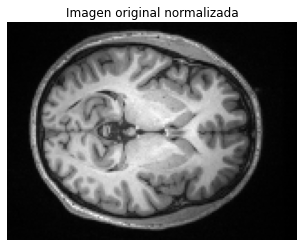

In [9]:
img_gray= a[:,:,128]
#normalizo la imagen
img_o=img_gray
img_o=img_o/np.max(img_o)
plt.title('Imagen original normalizada'), plt.axis('off')
plt.imshow(img_o, cmap=plt.cm.gray)


## 2. Conceptos teóricos del algoritmo Watershed

El algoritmo watersheed es una técnica de segmentación basada en morfología que permite encontrar regiones de una imagen.

Se considera una imagen numérica como un relieve topográfico, donde la intensidad del pixel se corresponde a la altura sobre el relieve.Si lo comparamos con la inundación del relieve topográfico, asumiendo que el agua nace de los mínimos regionales(zona plana tal que el nivel de todos los pixeles vecinos es estrictamente superior).

## 3. Flujo de la función .WatershedExerciseP2() creada

Hemos creado una función para el algoritmo watershed, **WatershedExerciseP2(img)** incluida en el archivo **modules.py**, que será la encargada de implementar una aproximación del algoritmo watershed:

1. Obtener el gradiente de la imagen:
        Hemos decidido aplicar el filtro derivativo **Sobel**. Los filtros derivativos son capaces de destacar las zonas con un alto contraste local.Estos filtros funcionan mediante el cálculo del gradiente que, en una imagen sería la diferencia de niveles de gris entre dos puntos de esta. Las zonas con un alto contraste local en una imagen son los bordes

2. Con la funcion de skimage, implementamos el algoritmo watershed cuyo parámetro será la imagen de gradiente calculada en el punto anterior.

3. Con la función **imimposemin** conseguimos modificar la imagen de tal forma que ésta tenga mínimo nivel de gris en los puntos considerados, convirtiéndose en mínimos locales. Para trabajar con esta función se deben introducir a la entrada dos imágenes:

        - La imagen de gradiente (calculada en el punto 1)
        - La imagen de máscara binaria del mismo tamaño que la imagen de gradiente, con los puntos donde queremos imponer los mínimos marcados.

4. Nuevamente, con la fución de skimage, implementamos el **algoritmo Watershed** cuyo parámetro será lo calculado con la función **imimposemin**

<img src="watershed.png" alt="watershed" width="750"/>

## 4. Ejemplo y discusión de resultados

Using matplotlib backend: Qt5Agg
[[46 71]
 [59 59]
 [32 80]]


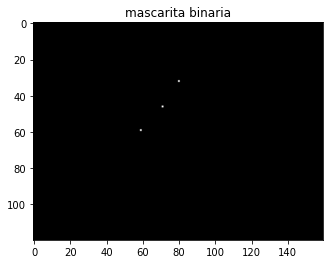

In [12]:
%matplotlib auto
watershed1, watershed2 =modules.WatershedExerciseP2(img_o,3)

img_sobel=filters.sobel(img_o) 
# 

(Text(0.5, 1.0, 'Watershed sobre máscara binaria'), (-0.5, 159.5, 119.5, -0.5))

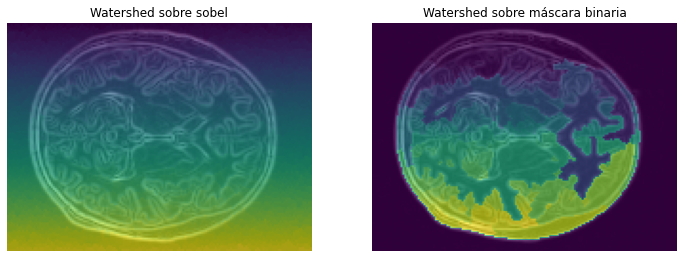

In [15]:
%matplotlib inline

fig = plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed1, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre sobel'), plt.axis('off')
plt.subplot(122)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed2, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre máscara binaria'), plt.axis('off')


### Características de las máscaras

Para poder comprender los resultados vamos a analizar las diferencias entre las dos salidas de nuestra función, watershed1 y watershed2.

En primer lugar tenemos nuestra salida **watershed1**, que se obtiene como resultado de aplicar la función .watershed() de **skimage** sobre la imagen de sobel. Debemos saber que la imagen de sobel es la representación del gradiente de la imagen original. En este caso consideramos que el gradiente es una función de altura donde los valores altos indican la presencia de bordes. Como vemos en el ejemplo, la aplicación sobre la imangen de sobel no es realmente efectiva, 

En segundo lugar tenemos la salida **watershed2**, que es el resultado de la aplicacion de la función .watershed() mencionada, pero esta vez con la imagen resultante de aplicar a la imagen de sobel la máscara binaria obtenida a partir de las semillas introducidas (en nuestro código se llama ***minimos***). Nótese que la transformación que realizamos a la imagen de sobel es la imposición de mínimos en los puntos marcados con nuestras semillas, suponiendo esto que el valor de dichos puntos sea igual a cero.

## 5. Referencias

## 6. Autoría


Esta práctica ha sido realizada por Mariana Nakagawa, María Pardo y Gema Pérez. Consideramos que las aportaciones de cada una en todos los puntos del trabajo se deben tener en cuenta. Hemos colaborado todas en la elaboración de cada algoritmo y en la solución de problemas.